In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [19]:
%matplotlib notebook

import numpy as np
import pandas as pd

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.datasets import Label
from coniferest.session import Session
from coniferest.session.callback import make_autonomous_experiment, autonomous_decider_callback
import matplotlib.pyplot as plt

import gzip
import tarfile
from tqdm import tqdm

In [4]:
def load_weather_dataset():
    "Weather dataset"
    with gzip.open('../datasets/weather/NEweather_data.csv.gz', 'rt') as file:
        data = np.genfromtxt(file, delimiter=',')

    with gzip.open('../datasets/weather/NEweather_class.csv.gz', 'rt') as file:
        labels = np.genfromtxt(file, delimiter=',')
        labels[labels == 2] = -1
    
    return data, labels

In [5]:
def load_galaxy_zoo2():
    "Galaxy Zoo 2 dataset"
    path = '../datasets/gz2/astronomaly.parquet'
    tbl = pd.read_parquet(path)
    data = tbl.drop(columns=['GalaxyID', 'anomaly']).to_numpy().copy(order='C')

    anomaly = tbl['anomaly'].to_numpy()
    labels = np.full(anomaly.shape, Label.R)
    labels[anomaly] = Label.A
    labels = labels

    ids = tbl['GalaxyID'].to_numpy()
    
    return data, labels, ids

In [61]:
def load_deviation_dataset(filename='KDD2014_donors_10feat_nomissing_normalised.csv'):
    "Loading of the datasets from deviation network paper"
    dirname = '../datasets/deviation-network/dataset/'

    path = dirname + filename
    if path.endswith('.csv'):
        rawdata = pd.read_csv(dirname + filename)
    elif path.endswith('.tar.xz'):
        with tarfile.open(path, 'r:xz') as file:
            rawdata = pd.read_csv(file.extractfile(file.next()))
    else:
        raise ValueError('unknown extension of file: {filename}')

    rawdata = pd.read_csv(dirname + filename)
    columns = [c for c in rawdata.columns if '=' not in c and c != 'class']
    data = rawdata[columns].to_numpy()
    labels = 1 - 2 * rawdata['class'].to_numpy()
    return data, labels

In [29]:
class CompareThem:
    def __init__(self, data, labels, budget=300, n_jobs=30, options=None):
        options = options or {}

        self.budget = budget

        self.isoforest_experiment = make_autonomous_experiment(labels, budget=budget)
        self.isoforest_session = Session(
            data, labels,
            model=IsolationForest(n_jobs=n_jobs, **options.get('isoforest', {})),
            decision_callback=autonomous_decider_callback,
            on_decision_callbacks=[self.isoforest_experiment])

        self.pineforest_experiment = make_autonomous_experiment(labels, budget=budget)
        self.pineforest_session = Session(
            data, labels,
            model=PineForest(n_jobs=n_jobs, **options.get('pineforest', {})),
            decision_callback=autonomous_decider_callback,
            on_decision_callbacks=[self.pineforest_experiment])

    def run(self):
        with tqdm(total=self.budget, ncols=80, desc='isoforest') as bar:
            self.isoforest_session._on_decision_cb.append(lambda *_: bar.update())
            self.isoforest_session.run()
        
        with tqdm(total=self.budget, ncols=80, desc='pineforest') as bar:
            self.pineforest_session._on_decision_cb.append(lambda *_: bar.update())
            self.pineforest_session.run()

    def plot(self, title='AD performance curves'):
        plt.figure(figsize=(8, 6))
        plt.title(title)
        
        def performance(exp):
            return np.cumsum(exp.labels == Label.A)

        plt.plot(performance(self.isoforest_experiment), label='Isolation Forest')
        plt.plot(performance(self.pineforest_experiment), label='Pine Forest')

        plt.xlabel('number of iteration')
        plt.ylabel('true anomalies detected')
        plt.grid()
        plt.legend()
        pass

<IPython.core.display.Javascript object>


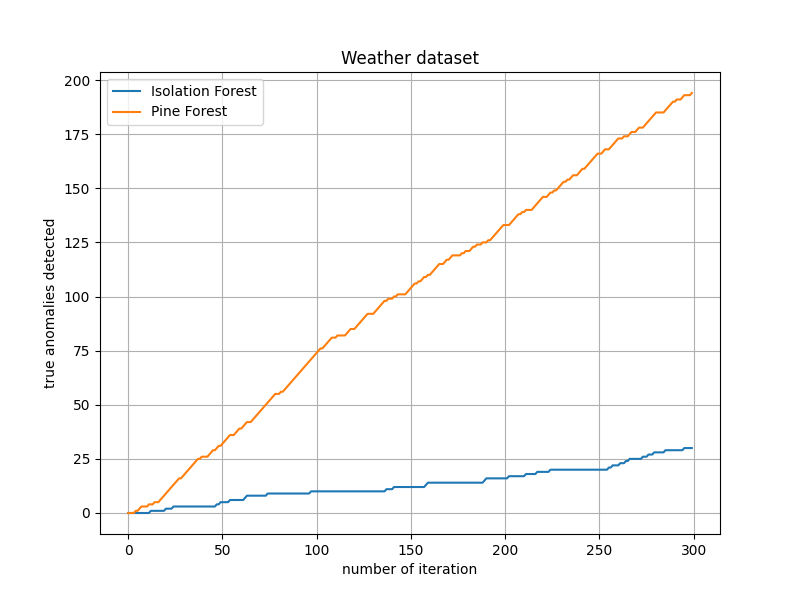

In [33]:
%%time

data, labels = load_weather_dataset()
weather_cmp = CompareThem(data, labels)
weather_cmp.run()
weather_cmp.plot(title='Weather dataset')

<IPython.core.display.Javascript object>


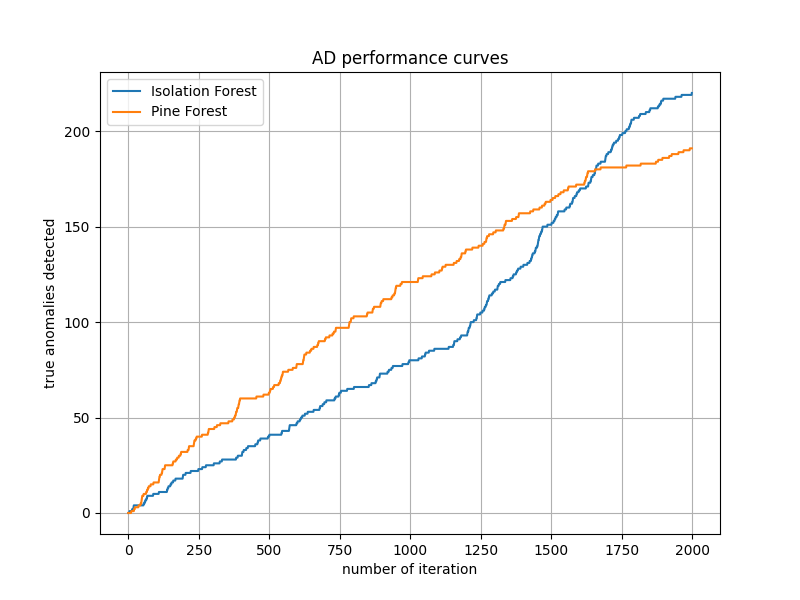

In [32]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'pineforest': pineopts }


data, labels, _ = load_galaxy_zoo2()
gzoo = CompareThem(data, labels, options=options, budget=2000)
gzoo.run()
gzoo.plot()

pineforest: 100%|█████████████████████████████| 300/300 [03:42<00:00,  1.35it/s]


<IPython.core.display.Javascript object>


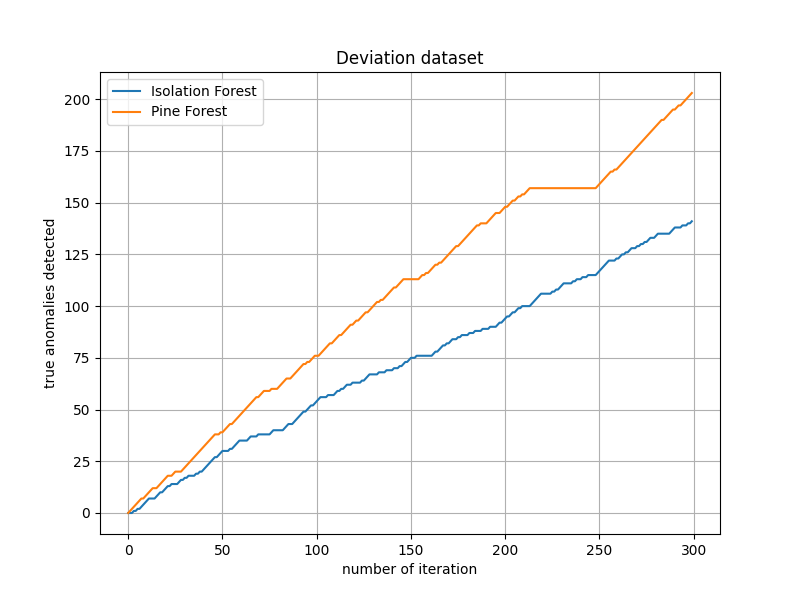

CPU times: user 52min 52s, sys: 4.06 s, total: 52min 56s
Wall time: 5min 38s


In [47]:
%%time

data, labels = load_deviation_dataset()
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')

pineforest: 100%|█████████████████████████████| 300/300 [02:47<00:00,  1.80it/s]


<IPython.core.display.Javascript object>


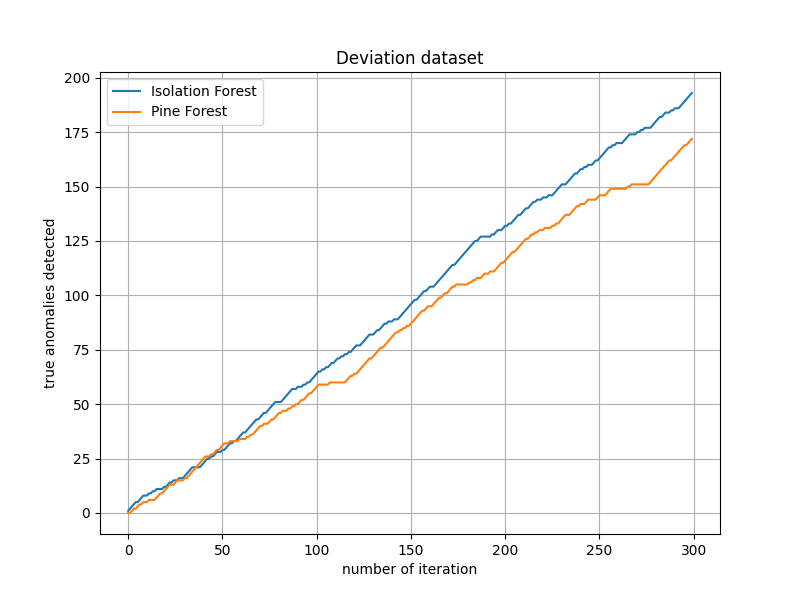

CPU times: user 14min 24s, sys: 2.08 s, total: 14min 26s
Wall time: 3min 41s


In [48]:
%%time

data, labels = load_deviation_dataset(filename='bank-additional-full_normalised.csv')
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')

pineforest: 100%|█████████████████████████████| 300/300 [01:36<00:00,  3.12it/s]


<IPython.core.display.Javascript object>


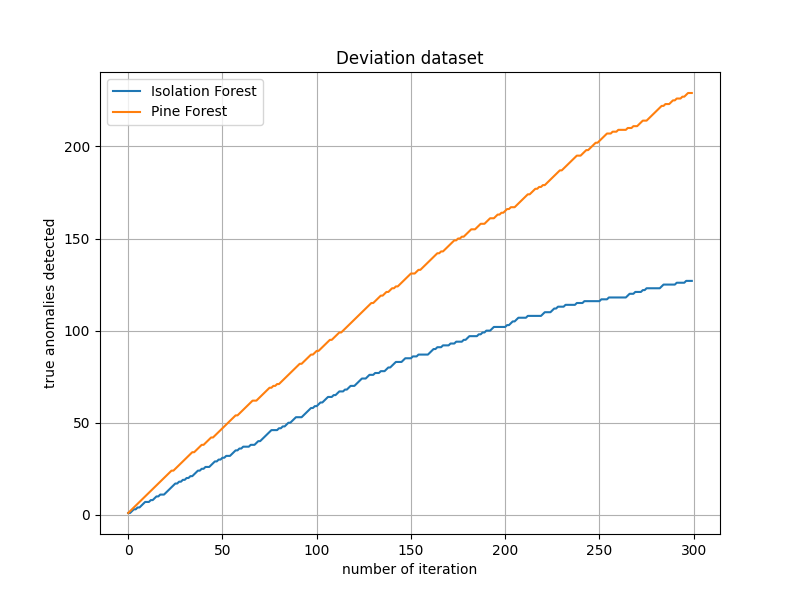

CPU times: user 9min 49s, sys: 2.39 s, total: 9min 51s
Wall time: 2min 4s


In [53]:
%%time

data, labels = load_deviation_dataset(filename='annthyroid_21feat_normalised.csv')
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')

pineforest: 100%|█████████████████████████████| 300/300 [03:32<00:00,  1.41it/s]


<IPython.core.display.Javascript object>


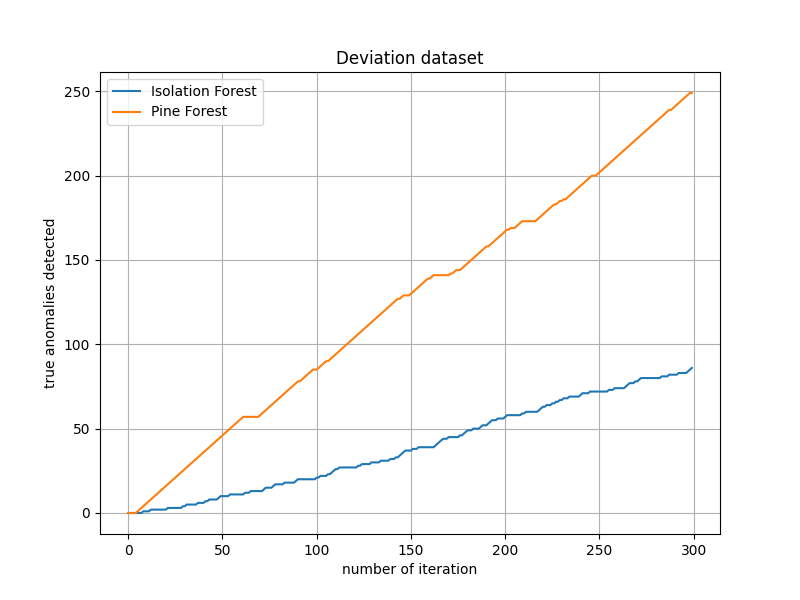

CPU times: user 36min 25s, sys: 3.16 s, total: 36min 28s
Wall time: 5min 12s


In [62]:
%%time

data, labels = load_deviation_dataset(filename='creditcardfraud_normalised.tar.xz')
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')

pineforest: 100%|█████████████████████████████| 300/300 [03:10<00:00,  1.58it/s]


<IPython.core.display.Javascript object>


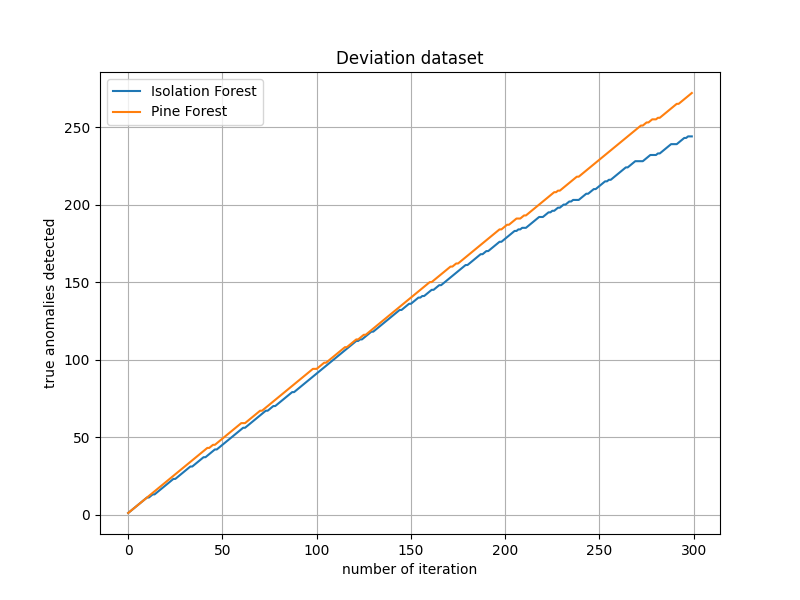

CPU times: user 28min 29s, sys: 6.07 s, total: 28min 36s
Wall time: 4min 41s


In [63]:
%%time

data, labels = load_deviation_dataset(filename='census-income-full-mixed-binarized.tar.xz')
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')

pineforest: 100%|█████████████████████████████| 300/300 [02:59<00:00,  1.67it/s]


<IPython.core.display.Javascript object>


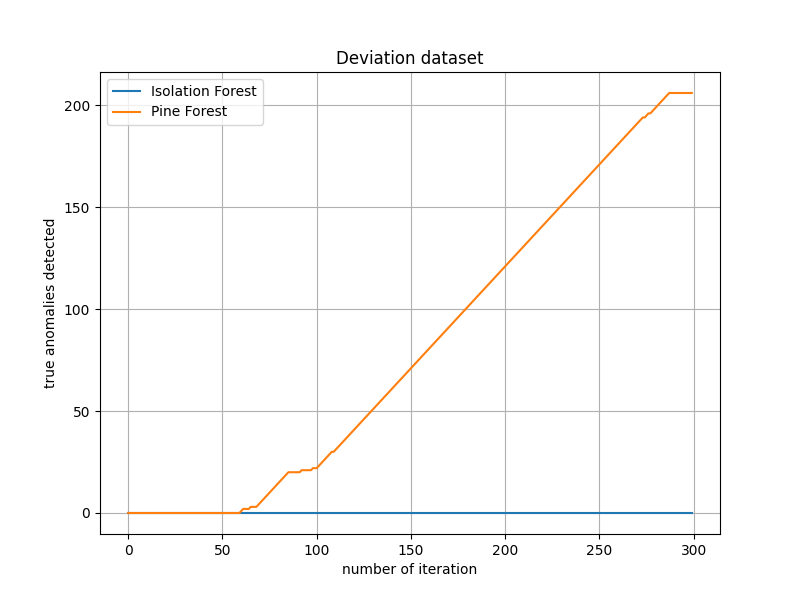

CPU times: user 15min 56s, sys: 2.16 s, total: 15min 58s
Wall time: 4min 2s


In [64]:
%%time

data, labels = load_deviation_dataset(filename='UNSW_NB15_traintest_backdoor.tar.xz')
deviation = CompareThem(data, labels)
deviation.run()
deviation.plot(title='Deviation dataset')